# Install and import all the packages

In [ ]:
!pip install combat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 231 kB 8.0 MB/s 
     |████████████████████████████████| 9.5 MB 52.5 MB/s 
     |████████████████████████████████| 14.8 MB 44.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.2
    Uninstalling patsy-0.5.2:
      Successfully uninstalled patsy-0.5.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorfl

In [ ]:
from tcga_downloader import *
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from combat.pycombat import pycombat
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
import csv
import re

# Download all the miRNA expression data files from TCGA
1. Upload TCGA downloader
2. Upload the manifest file

In [ ]:
#createa metadata file from manifest file and download all data from TCGA
def download_files(manifestfile):
  ids=get_ids(manifestfile)
  #len(ids)
  payload=prepare_payload(ids,data_type='Gene Expression Quantification')
  global metadata
  metadata=get_metadata(payload)
  download_data(metadata,sep='\t',outdir='lung cancer')
  return metadata


In [ ]:
download_files("/content/GE_manifest.txt")

curl --request POST --header "Content-Type: application/json" --data @payloadv3.txt 'https://api.gdc.cancer.gov/files' > Metadata.tsv


EmptyDataError: ignored

In [ ]:
#create lists for cptac and luad files
def get_cptac_luad_id_list(metadata):  
    df=pd.read_table(metadata)
    #store file id of luad and cptac file in seperate lists
    global luad
    global cptac
    luad=[]
    cptac=[]
    for i in df['cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id']:
      if i.startswith("T"):
        luad_file=str(df.loc[df['cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id']==i,'file_name']).split("\n")
        luad.append(luad_file[0].split()[1].split(".")[0])
      else:
        cptac_file=str(df.loc[df['cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id']==i,'file_name']).split("\n")
        cptac.append(cptac_file[0].split()[1])
    return (print('luad is', len(luad),'\n','cptac is', len(cptac)))
    #return (print('cptac is', len(cptac)))

    #print(luad,'\n', cptac)

#create lists for normal and tumor samples
def primarytumour_normal_lists():
  # Get the list of all files for tumour and normal samples seperately
  path = "/content/lung cancer/Primary Tumor"
  global infected_list
  infected_list = os.listdir(path)
  #infected_list.sort()
  path = "/content/lung cancer/Solid Tissue Normal"
  global normal_list
  normal_list = os.listdir(path)
  #print(type(normal_list))
  #normal_list.sort()
  return print('tumour', len(infected_list),'\n','normal',len(normal_list))


In [ ]:
get_cptac_luad_id_list("/content/Metadata.tsv")

luad is 528 
 cptac is 213


In [ ]:
primarytumour_normal_lists()

tumour 592 
 normal 147


# Data Imputation

#Mean method

In [ ]:
def data_imputation_mean():
  #seperate the tumour and normal data before imputation
  #create a dataframe for tumour samples
  os.chdir('/content/lung cancer/Primary Tumor')
  tumour=pd.read_table('02e51370-8ffb-4be1-8ca1-279cbb92cd55.mirnaseq.mirnas.quantification.txt')
  data_tumour={'miRNA_ID':tumour['miRNA_ID']}
  for tfile in infected_list:
      fname_start=tfile
      df_file=pd.read_table(tfile)
      data_tumour[fname_start]=df_file['read_count']
  df_tumour = pd.DataFrame.from_dict(data_tumour)
  os.chdir('/content')
  df_tumour.to_csv("combined_tumour.csv")

  #create a dataframe for normal samples samples
  os.chdir('/content/lung cancer/Solid Tissue Normal')
  normal=pd.read_table('000c2ed5-7174-4152-9682-9bd149508187.mirnaseq.mirnas.quantification.txt')
  data_normal={'miRNA_ID':normal['miRNA_ID']}
  for nfile in normal_list:
      fname_start_normal=nfile
      df_file_normal=pd.read_table(nfile)
      data_normal[fname_start_normal]=df_file_normal['read_count']
  df_normal = pd.DataFrame.from_dict(data_normal)
  os.chdir('/content')
  df_normal.to_csv("combined_normal.csv")
  #df_normal.shape
  #df_tumour.shape

  #drop the unrequired columns
  df1=pd.read_csv('combined_tumour.csv',index_col=1)
  df1.drop('Unnamed: 0', axis=1, inplace=True)
  df2=pd.read_csv('combined_normal.csv',index_col=1)
  df2.drop('Unnamed: 0', axis=1, inplace=True)

  # drop rows that have only NAs
  df1=df1.replace(0,np.NaN)
  df1 = df1.dropna(how='all')

  #create a column with mean for each mirna
  df1['meantumor'] = df1.mean(axis=1)

  #replace the nan values with tumour mean
  for cols in df1.columns:
    df1[cols].fillna(value=df1['meantumor'], inplace=True)
  df1 = df1.drop(['meantumor'], axis = 1)
  df1=df1.replace(np.NaN,0)

  # drop rows that have only NAs
  df2=df2.replace(0,np.NaN)
  df2 = df2.dropna(how='all')

  #create a column with mean for each mirna
  df2['meannormal'] = df2.mean(axis=1)

  #replace the nan values with normal mean
  for cols in df2.columns:
    df2[cols].fillna(value=df2['meannormal'], inplace=True)
  df2 = df2.drop(['meannormal'], axis = 1)
  df2=df2.replace(np.NaN,0)

  #rejoin the normal and tumour data
  df3 = df1.merge(df2, on=['miRNA_ID'],how='inner')

  global df_expression

  #drop all the rows with mean = 0
  df3=df3.replace(0,np.NaN)
  df_expression = df3.dropna(axis=0, how='all')

  #replace the nan values with 0 (nans are not allowed in pycombat)
  df_expression=df_expression.replace(np.NaN,0)
  #df_expression = df_expression.reset_index(drop=True)
 

  return df_expression

In [ ]:
data_imputation_mean()

,038cea02-cec0-4699-b18d-40a3428624d3.mirbase21.mirnas.quantification.txt,7ee9263f-dfa1-485a-9292-308fb6316bff.mirbase21.mirnas.quantification.txt,f692278d-a164-4645-b843-ce2bf6007a20.mirbase21.mirnas.quantification.txt,80f2c0c3-5e9b-45e9-9b94-f4546761e93a.mirnaseq.mirnas.quantification.txt,8f9a2c61-64e2-4140-919c-157639d383d3.mirbase21.mirnas.quantification.txt,be429e5d-7de9-43f5-bed1-dfacbba548a3.mirbase21.mirnas.quantification.txt,b537111d-ad3e-499c-88a9-48d23841794d.mirbase21.mirnas.quantification.txt,90856054-862e-41ee-8305-984433fef9fe.mirbase21.mirnas.quantification.txt,3befce99-d1e0-4420-bd5d-7cdd3e8db66b.mirbase21.mirnas.quantification.txt,865f8168-24a0-46b7-ae90-acf6fcc63850.mirnaseq.mirnas.quantification.txt,...,2bcb1b22-6848-4cfd-a520-746417b2eddd.mirnaseq.mirnas.quantification.txt,efc80726-3758-4dac-9bda-2432622db080.mirnaseq.mirnas.quantification.txt,3104d4a5-a3ee-439d-932a-9e00f2f17d29.mirnaseq.mirnas.quantification.txt,2288a1aa-8f29-4a29-a619-2c49fde819ae.mirbase21.mirnas.quantification.txt,dab3b661-16df-4dcf-867a-f4634a881cdb.mirnaseq.mirnas.quantification.txt,fccddf3b-fdef-485f-a658-2c37af30f7da.mirnaseq.mirnas.quantification.txt,19a67a21-813e-4c69-a93d-4aca7036bbdd.mirnaseq.mirnas.quantification.txt,110fa573-76d1-4db3-bcd9-b83bb23bd368.mirbase21.mirnas.quantification.txt,bb241140-3835-43cb-b204-2917e4902c6b.mirnaseq.mirnas.quantification.txt,49c0d897-7aae-407a-b5b0-73d3e00f978d.mirnaseq.mirnas.quantification.txt
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,48626.0,46416.0,18069.0,137898.0,30795.0,16988.0,44628.0,189721.0,21353.0,242089.0,...,304501.0,239310.0,376199.0,33456.0,336597.0,242135.0,284026.0,101216.0,411683.0,242320.0
hsa-let-7a-2,48393.0,46299.0,18304.0,131446.0,30587.0,16719.0,44387.0,190161.0,21317.0,231163.0,...,293547.0,228269.0,363189.0,33408.0,321335.0,234178.0,271877.0,100996.0,393971.0,233207.0
hsa-let-7a-3,48404.0,46627.0,18330.0,131769.0,30724.0,17083.0,44701.0,190469.0,21496.0,231770.0,...,292875.0,227629.0,361980.0,33325.0,321881.0,233864.0,271588.0,100894.0,392790.0,233675.0
hsa-let-7b,74723.0,55752.0,52247.0,37786.0,51520.0,35855.0,45030.0,116664.0,11884.0,63171.0,...,95366.0,84920.0,116615.0,30737.0,101763.0,87748.0,93149.0,94917.0,129235.0,76232.0
hsa-let-7c,2744.0,2645.0,5544.0,8807.0,2844.0,2413.0,4861.0,11303.0,1048.0,21287.0,...,25638.0,22937.0,26196.0,3853.0,51188.0,22437.0,30539.0,11138.0,39187.0,20440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-95,24.0,8.0,17.0,1708.0,5.0,4.0,10.0,24.0,61.0,4212.0,...,1682.0,1708.0,1659.0,3.0,2477.0,1674.0,2421.0,5.0,2757.0,1388.0
hsa-mir-96,197.0,95.0,99.0,1623.0,71.0,88.0,174.0,428.0,19.0,2484.0,...,682.0,218.0,347.0,6.0,377.0,445.0,247.0,33.0,774.0,356.0
hsa-mir-98,364.0,313.0,234.0,16233.0,105.0,220.0,204.0,1219.0,31.0,30362.0,...,15350.0,11211.0,17823.0,147.0,14963.0,13356.0,11064.0,392.0,19883.0,19917.0


In [ ]:
def check_zeroes_and_nulls():
  #check for any remaining null values
  count=0
  for column_name in df_expression.columns:
      column = df_expression[column_name]
      # Get the count of Zeros in column 
      count = (column == 0).sum()
      count+=count
  print("the number of zeroes", count)
  print("presence of null values", df_expression.isnull().values.any())
  

In [ ]:
check_zeroes_and_nulls()

the number of zeroes 0
presence of null values False


#KNN Method

In [ ]:
def data_imputation_knn():
    #create a dataframe for tumour samples
    os.chdir('/content/lung cancer/Primary Tumor')
    tumour=pd.read_table('02e51370-8ffb-4be1-8ca1-279cbb92cd55.mirnaseq.mirnas.quantification.txt')
    data_tumour={'miRNA_ID':tumour['miRNA_ID']}
    for tfile in infected_list:
        fname_start=tfile
        df_file=pd.read_table(tfile)
        data_tumour[fname_start]=df_file['read_count']
    df_tumour = pd.DataFrame.from_dict(data_tumour)
    os.chdir('/content')
    df_tumour.to_csv("combined_tumour.csv")

    #create a dataframe for normal samples samples
    os.chdir('/content/lung cancer/Solid Tissue Normal')
    normal=pd.read_table('000c2ed5-7174-4152-9682-9bd149508187.mirnaseq.mirnas.quantification.txt')
    data_normal={'miRNA_ID':normal['miRNA_ID']}
    for nfile in normal_list:
        fname_start_normal=nfile
        df_file_normal=pd.read_table(nfile)
        data_normal[fname_start_normal]=df_file_normal['read_count']
    df_normal = pd.DataFrame.from_dict(data_normal)
    os.chdir('/content')
    df_normal.to_csv("combined_normal.csv")

    #read the normal and tumor files
    df1=pd.read_csv('combined_tumour.csv',index_col=1)
    df1.drop('Unnamed: 0', axis=1, inplace=True)
    df2=pd.read_csv('combined_normal.csv',index_col=1)
    df2.drop('Unnamed: 0', axis=1, inplace=True)

    #drop all rows with mean 0
    df1 = df1.replace(0, np.NaN)
    df2 = df2.replace(0,np.NaN)
    df1 = df1.dropna(axis=0, how='all')
    df2 = df2.dropna(axis=0, how='all')

    #impute both tumor and normal sample seperately
    imputer = KNNImputer()
    df1 = df1.replace(0, np.NaN)
    df1 [:] = imputer.fit_transform(df1)
    imputer = KNNImputer()
    df2 = df2.replace(0, np.NaN)
    df2[:] = imputer.fit_transform(df2)
    

    #recombine normal and tumour datasets
    global df_expression_knn
    df_expression_knn = df1.merge(df2, on=['miRNA_ID'],how='outer')
    df_expression_knn = df_expression_knn.replace(np.NaN,0)

    return df_expression_knn




In [ ]:
data_imputation_knn()

,038cea02-cec0-4699-b18d-40a3428624d3.mirbase21.mirnas.quantification.txt,7ee9263f-dfa1-485a-9292-308fb6316bff.mirbase21.mirnas.quantification.txt,f692278d-a164-4645-b843-ce2bf6007a20.mirbase21.mirnas.quantification.txt,80f2c0c3-5e9b-45e9-9b94-f4546761e93a.mirnaseq.mirnas.quantification.txt,8f9a2c61-64e2-4140-919c-157639d383d3.mirbase21.mirnas.quantification.txt,be429e5d-7de9-43f5-bed1-dfacbba548a3.mirbase21.mirnas.quantification.txt,b537111d-ad3e-499c-88a9-48d23841794d.mirbase21.mirnas.quantification.txt,90856054-862e-41ee-8305-984433fef9fe.mirbase21.mirnas.quantification.txt,3befce99-d1e0-4420-bd5d-7cdd3e8db66b.mirbase21.mirnas.quantification.txt,865f8168-24a0-46b7-ae90-acf6fcc63850.mirnaseq.mirnas.quantification.txt,...,2bcb1b22-6848-4cfd-a520-746417b2eddd.mirnaseq.mirnas.quantification.txt,efc80726-3758-4dac-9bda-2432622db080.mirnaseq.mirnas.quantification.txt,3104d4a5-a3ee-439d-932a-9e00f2f17d29.mirnaseq.mirnas.quantification.txt,2288a1aa-8f29-4a29-a619-2c49fde819ae.mirbase21.mirnas.quantification.txt,dab3b661-16df-4dcf-867a-f4634a881cdb.mirnaseq.mirnas.quantification.txt,fccddf3b-fdef-485f-a658-2c37af30f7da.mirnaseq.mirnas.quantification.txt,19a67a21-813e-4c69-a93d-4aca7036bbdd.mirnaseq.mirnas.quantification.txt,110fa573-76d1-4db3-bcd9-b83bb23bd368.mirbase21.mirnas.quantification.txt,bb241140-3835-43cb-b204-2917e4902c6b.mirnaseq.mirnas.quantification.txt,49c0d897-7aae-407a-b5b0-73d3e00f978d.mirnaseq.mirnas.quantification.txt
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,48626.0,46416.0,18069.0,137898.0,30795.0,16988.0,44628.0,189721.0,21353.0,242089.0,...,304501.0,239310.0,376199.0,33456.0,336597.0,242135.0,284026.0,101216.0,411683.0,242320.0
hsa-let-7a-2,48393.0,46299.0,18304.0,131446.0,30587.0,16719.0,44387.0,190161.0,21317.0,231163.0,...,293547.0,228269.0,363189.0,33408.0,321335.0,234178.0,271877.0,100996.0,393971.0,233207.0
hsa-let-7a-3,48404.0,46627.0,18330.0,131769.0,30724.0,17083.0,44701.0,190469.0,21496.0,231770.0,...,292875.0,227629.0,361980.0,33325.0,321881.0,233864.0,271588.0,100894.0,392790.0,233675.0
hsa-let-7b,74723.0,55752.0,52247.0,37786.0,51520.0,35855.0,45030.0,116664.0,11884.0,63171.0,...,95366.0,84920.0,116615.0,30737.0,101763.0,87748.0,93149.0,94917.0,129235.0,76232.0
hsa-let-7c,2744.0,2645.0,5544.0,8807.0,2844.0,2413.0,4861.0,11303.0,1048.0,21287.0,...,25638.0,22937.0,26196.0,3853.0,51188.0,22437.0,30539.0,11138.0,39187.0,20440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-5186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.6,9.2,5.0,4.6,7.6,3.8,9.2,6.8,7.6,5.2
hsa-mir-619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2.0,8.8,1.2,5.2,4.0,3.8,3.8,13.8,8.2
hsa-mir-8052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,6.0,20.0,1.4,39.6,18.8,47.6,3.4,11.2,10.2


#Batch Correction

In [ ]:
def batch_correction(imputated_data):
  #create batch ids for you samples
  #here luad samples = 1
  #and cptac samples = 2
  global batch_ids
  batch_ids=[]
  #print(len(df1.columns))
  for filename in imputated_data.columns:
      if filename.split(".")[0] in luad:
        batch_ids.append(1)
      else:
          batch_ids.append(2)

  #run batch correction using pycombat
  global df_corrected
  df_corrected = pycombat(imputated_data,batch_ids,mean_only=False)
  df_corrected.to_csv('batch_corrected_luad_cptac.csv')

  return df_corrected


In [ ]:
batch_correction(df_expression_knn)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,038cea02-cec0-4699-b18d-40a3428624d3.mirbase21.mirnas.quantification.txt,7ee9263f-dfa1-485a-9292-308fb6316bff.mirbase21.mirnas.quantification.txt,f692278d-a164-4645-b843-ce2bf6007a20.mirbase21.mirnas.quantification.txt,80f2c0c3-5e9b-45e9-9b94-f4546761e93a.mirnaseq.mirnas.quantification.txt,8f9a2c61-64e2-4140-919c-157639d383d3.mirbase21.mirnas.quantification.txt,be429e5d-7de9-43f5-bed1-dfacbba548a3.mirbase21.mirnas.quantification.txt,b537111d-ad3e-499c-88a9-48d23841794d.mirbase21.mirnas.quantification.txt,90856054-862e-41ee-8305-984433fef9fe.mirbase21.mirnas.quantification.txt,3befce99-d1e0-4420-bd5d-7cdd3e8db66b.mirbase21.mirnas.quantification.txt,865f8168-24a0-46b7-ae90-acf6fcc63850.mirnaseq.mirnas.quantification.txt,...,2bcb1b22-6848-4cfd-a520-746417b2eddd.mirnaseq.mirnas.quantification.txt,efc80726-3758-4dac-9bda-2432622db080.mirnaseq.mirnas.quantification.txt,3104d4a5-a3ee-439d-932a-9e00f2f17d29.mirnaseq.mirnas.quantification.txt,2288a1aa-8f29-4a29-a619-2c49fde819ae.mirbase21.mirnas.quantification.txt,dab3b661-16df-4dcf-867a-f4634a881cdb.mirnaseq.mirnas.quantification.txt,fccddf3b-fdef-485f-a658-2c37af30f7da.mirnaseq.mirnas.quantification.txt,19a67a21-813e-4c69-a93d-4aca7036bbdd.mirnaseq.mirnas.quantification.txt,110fa573-76d1-4db3-bcd9-b83bb23bd368.mirbase21.mirnas.quantification.txt,bb241140-3835-43cb-b204-2917e4902c6b.mirnaseq.mirnas.quantification.txt,49c0d897-7aae-407a-b5b0-73d3e00f978d.mirnaseq.mirnas.quantification.txt
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,97214.158278,94104.424017,54216.805429,42425.436060,72123.809139,52695.709169,91588.494218,295751.694690,58837.786113,112429.899810,...,154363.642566,110562.728895,202536.517785,75868.154328,175928.492395,112460.806561,140606.778775,171214.576719,226377.717041,112585.105452
hsa-let-7a-2,94463.406077,91587.012527,53132.075827,40730.777732,70004.445446,50954.862944,88960.620708,289201.018723,57270.840759,108667.445536,...,151169.336730,106695.778552,198616.065164,73879.472288,170101.155025,110721.549183,136405.679668,166720.774722,219587.679917,110060.011989
hsa-let-7a-3,94379.536659,91943.780854,53156.734137,41000.245956,70145.342717,51447.455865,89303.788912,289109.783393,57496.409364,109217.708919,...,150901.572824,106392.852026,198042.779193,73710.565480,170688.532262,110646.168309,136380.266696,166328.226702,219060.369356,110517.238593
hsa-let-7b,75150.437663,57973.151093,54799.549837,20308.299847,54141.287893,39957.418085,48264.919233,113125.904221,18252.882932,57146.674333,...,103867.630274,88708.533962,134703.896552,35323.326436,113150.871621,92812.489962,100650.349351,93435.089237,153017.872759,76100.623876
hsa-let-7c,6138.246363,6001.562940,10004.040164,1457.630630,6276.310428,5681.254310,9061.062605,17955.149628,3796.679833,9935.551479,...,12891.275326,11056.430437,13270.336210,7669.376836,30247.916166,10716.770147,16220.625493,17727.343922,22095.389876,9360.166947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-5186,0.591597,0.591597,0.591597,-0.903455,0.591597,0.591597,0.591597,0.591597,0.591597,-0.903455,...,1.759980,4.423415,1.991583,11.164325,3.497003,1.296774,4.423415,16.220847,3.497003,2.107384
hsa-mir-619,0.467492,0.467492,0.467492,-0.690167,0.467492,0.467492,0.467492,0.467492,0.467492,-0.690167,...,2.900188,0.506618,4.575687,2.788097,2.421474,1.703403,1.583724,7.816075,7.567649,4.216651
hsa-mir-8052,1.221629,1.221629,1.221629,-2.382147,1.221629,1.221629,1.221629,1.221629,1.221629,-2.382147,...,13.946010,0.883485,8.503291,9.610229,19.171020,7.850165,23.525195,21.593943,3.713699,3.169427


#Generate PCA Plot

In [ ]:
def pca_plot(data,normal_samples,tumor_samples):
  sample_ids=[]
  for i in range(1,tumor_samples+1):
    sample_ids.append(1)
  for i in range(1,normal_samples+1):
    sample_ids.append(2)
  #transpose data as per pca plot requirement
  transpose=data.T
  transpose['sample_type']=sample_ids
  transpose.set_index('sample_type', inplace=True)
  #display(transpose)

  #scale the data
  scaler=StandardScaler()
  scaled_data=scaler.fit_transform(transpose)
  pca = PCA(2)
  pca.fit(scaled_data) 
  pca_data = pca.transform(scaled_data)

  #The following code constructs the Scree plot
  per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
  labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
  plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
  plt.ylabel('Percentage of Explained Variance')
  plt.xlabel('Principal Component')
  plt.title('Scree Plot')
  #f = plt.figure()
  #f.set_figwidth(80)
  #f.set_figheight(80)
  #f.show()

  #generate the pca plot
  pca_df=pd.DataFrame(pca_data, columns=labels)
  plt.scatter(pca_df.PC1,pca_df.PC2,c=transpose.index)
  plt.title('PCA_BEFORE')
  plt.xlabel('PC1 - {0}%'.format(per_var[0]))
  plt.ylabel('PC2 - {0}%'.format(per_var[1]))
  #plt.figure(figsize=(50,50))
  plt.show()

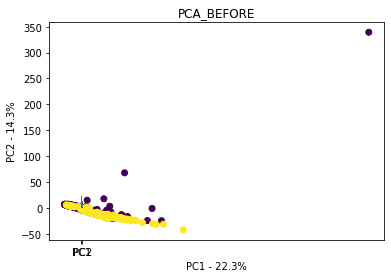

In [ ]:
pca_plot(df_expression_knn,147,592)

In [ ]:
batch_corrected =pd.read_csv('batch_corrected_luad_cptac_mean_inner.csv',index_col=0)
tumour_df = batch_corrected.iloc[: , 0:593].copy()
normal_df = batch_corrected.iloc[: , 592:].copy()
normal_df

,8345f95c-269f-476b-82a5-0630ee50b97b.mirbase21.mirnas.quantification.txt,9ef82d7a-76d1-4065-a5d5-cf11dfd659d5.mirnaseq.mirnas.quantification.txt,b7a508dd-6a32-456d-910e-6f3fe75856d3.mirbase21.mirnas.quantification.txt,b87a4576-508d-487c-99ac-e909fc31b833.mirnaseq.mirnas.quantification.txt,0b8bf198-6cfd-4779-bd57-3b5626b56acb.mirnaseq.mirnas.quantification.txt,68d627ed-4a56-40b0-a630-56867408e4d3.mirnaseq.mirnas.quantification.txt,d7a93eb7-6a1c-4615-8a16-a06ed344d18f.mirnaseq.mirnas.quantification.txt,a1178c43-ff0d-409b-8c1b-43621e6b4276.mirnaseq.mirnas.quantification.txt,5f0feb17-4be7-4144-9625-423d89eae22d.mirbase21.mirnas.quantification.txt,da6f74c6-84e2-4252-b598-c601e881028b.mirbase21.mirnas.quantification.txt,...,f4956d88-4146-49b2-9a96-ad57b3b5f97a.mirbase21.mirnas.quantification.txt,75a87357-78e9-45f9-a106-da1cdb3074b7.mirnaseq.mirnas.quantification.txt,1d833b10-385d-45ec-a1b5-795f1b04483c.mirnaseq.mirnas.quantification.txt,9c28d7c3-cb61-490c-bd47-58f6396ea6e0.mirnaseq.mirnas.quantification.txt,3e2478c8-d006-4546-9a5f-a9e6489d2f1a.mirbase21.mirnas.quantification.txt,00413a1b-1be7-4a6b-b133-d9cb91fc949c.mirnaseq.mirnas.quantification.txt,e678aebb-88bc-48e5-acb9-8104f9296a90.mirnaseq.mirnas.quantification.txt,8b5c41d3-63a1-402a-9657-36d305ebfbc2.mirbase21.mirnas.quantification.txt,bb7b5b83-056e-4c44-90fd-e50ed3b64e16.mirbase21.mirnas.quantification.txt,78ec4cda-26a0-41cf-9bfa-1e69ae2beab5.mirbase21.mirnas.quantification.txt
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,223670.710178,305146.959229,139600.710178,197592.959229,388396.959229,264397.959229,209063.959229,306150.959229,27577.710178,185552.710178,...,151852.710178,239622.959229,267160.959229,286734.959229,34020.710178,191244.959229,218086.959229,108239.710178,159056.710178,127387.710178
hsa-let-7a-2,222824.434907,293162.268563,140315.434907,191131.268563,369116.268563,254554.268563,201414.268563,292073.268563,27085.434907,184816.434907,...,151665.434907,229580.268563,258237.268563,276152.268563,33384.434907,182379.268563,210521.268563,108051.434907,158341.434907,126191.434907
hsa-let-7a-3,222997.447017,293289.993758,139622.447017,190258.993758,369013.993758,254524.993758,200199.993758,292236.993758,27094.447017,184593.447017,...,150675.447017,227874.993758,256519.993758,276054.993758,33384.447017,181482.993758,209829.993758,107766.447017,158774.447017,126356.447017
hsa-let-7b,153958.030190,82662.778049,89713.030190,76037.778049,132885.778049,81305.778049,68870.778049,90057.778049,74436.030190,134288.030190,...,101184.030190,91416.778049,102688.778049,68933.778049,137552.030190,62909.778049,83688.778049,76775.030190,80961.030190,69705.030190
hsa-let-7c,22432.559290,34063.859934,18416.559290,23027.859934,56552.859934,29504.859934,21314.859934,42697.859934,7154.559290,19875.559290,...,18923.559290,22026.859934,28301.859934,26834.859934,9770.559290,24773.859934,18511.859934,13022.559290,13714.559290,21366.559290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-95,278.117149,1486.753396,262.117149,1083.753396,3467.753396,1993.753396,1135.753396,2062.753396,252.117149,277.117149,...,274.117149,1141.753396,1113.753396,1046.753396,252.117149,1060.753396,760.753396,263.117149,264.117149,284.117149
hsa-mir-96,130.818123,26.875932,139.818123,0.000000,0.000000,47.875932,0.000000,0.000000,1266.361431,130.818123,...,135.818123,50.875932,21.875932,0.000000,1524.584922,0.000000,66.875932,145.818123,130.818123,149.818123
hsa-mir-98,2074.065657,13980.557434,1927.065657,8737.557434,12063.557434,13372.557434,12606.557434,12468.557434,1567.065657,1955.065657,...,1918.065657,14803.557434,10306.557434,14781.557434,1571.065657,4869.557434,9389.557434,1882.065657,1872.065657,1877.065657


# DE Analysis manually

In [ ]:
def de_analysis(df_tumour,df_normal):
  import numpy
  df_tumour["mean_tumour"]=df_tumour.mean(axis=1)
  df_normal["mean_normal"]=df_normal.mean(axis=1)
  de={'miRNA_ID':df_tumour.index,'log2FC':numpy.log2(df_tumour["mean_tumour"]/df_normal["mean_normal"])}
  df_de=pd.DataFrame.from_dict(de)
  df_de.to_csv("differential expression_mean_inner.csv")

In [ ]:
de_analysis(tumour_df,normal_df)

#Differential expression analysis using DESeq2

In [ ]:
%load_ext rpy2.ipython
%%r
library(DESeq2)
library(apeglm)
dat<-read.csv("batch_corrected_luad_cptac.csv", header=T, row.names=1)
info<-read.table("phenodata.txt", header=T, sep = '\t',fill=T)
dds<-DESeqDataSetFromMatrix(dat, info, ~diseaseStatus)
if ( any( counts(dat) < 0 ) )
return( "the count data contains negative values" )
any(dat<0)
keep<- rowSums(counts(dds))>=10
dds<-dds[keep,]
ddsDE<-DESeq(dds)
normCounts<-counts(ddsDE, normalized=T)
write.csv(normCounts,"normaldata.csv")
res<-results(ddsDE, alpha=0.05)
resOrdered<-res[order(res$padj),]
write.csv(resOrdered,"DESeq.file.csv")

##using an online webtool extract the gene targets for top differentiall expressed miRNA - https://www.mirnet.ca/upload/MirUploadView.xhtml
Differential expression analysis performed using excel only


#Collect an aggregate log2fc value of miRNA for each gene
1. Upload the DESeq2 created file
2. miRNA to gene mapped file

In [40]:
#create miRNA target list for each gene
df_mirnet=pd.read_csv('/content/mir2gene_manual_DE_Cal.csv')
group = df_mirnet.groupby('Target')
df2 = group.apply(lambda x: pd.Series({'miRNA_ID':x['ID'].unique()}))
#os.mkdir("/content/output_files1")
df2.to_csv("genes_mirna_mapped_manual.csv")

#Split the whole gene file into multiple smaller files
def split(filehandler, delimiter=',', row_limit=1000,
          output_name_template='output_%s.csv', output_path='/content/output_files1', keep_headers=True):
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w+'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w+'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)
        global file_list
        file_list = os.listdir(output_path)
#split(open('genes_mirna_mapped.csv', 'r'));

In [41]:
#compute the aggregate value for each gene
def cal_gene_aggregate_values(gene_file,mirna_de_value_file):
  df_luad_cptac=pd.read_csv(mirna_de_value_file)
  global gene_aggregate
  gene_aggregate={}
  df2_try=pd.read_csv(gene_file)
  final=[]
  count=0
  for index, row in df2_try.iterrows():
        l1 = str(row[1])[1:-1]
        l=l1.split(" ")
        l2=[]
        for i in l:
          new_string=i.strip("'")
          chomped=new_string.replace("'\n", "")
          chomped=re.sub("(-3p)|(-5p)","",chomped)
          l2.append(chomped)
        l4=[]
        for x in l2:
              #print(x)
              if x in df_luad_cptac.values:
                  l4.append(float(df_luad_cptac.loc[df_luad_cptac['miRNA_ID']==x,'log2FC']))
              else:
                l4.append(0)
        if (len(l4)!=0):
            avg=sum(l4)/len(l4)
            count=count+1
        gene_aggregate[row[0]]=avg  
  return gene_aggregate

  
#map the gene and aggregate value into a dataframe
def create_gene_agg_dataframe():
  genes=[]
  aggregate=[]
  for key, value in gene_aggregate.items():
      genes.append(key)
      aggregate.append(value)
  final={'genes':genes,'aggregate':aggregate}  
  f1 = pd.DataFrame.from_dict(final)
  f1.to_csv('final_gene_aggregate_manual_DE.csv')

In [42]:
import re
cal_gene_aggregate_values('/content/genes_mirna_mapped_manual.csv','/content/differential expression_knn.csv')

{'A1BG': 1.45931067,
 'A1CF': 1.1893838568421053,
 'A2M': -0.7518136255,
 'A2ML1': 0.9974191870000001,
 'A4GALT': 1.2330964188571427,
 'AAAS': 0.0977052262,
 'AACS': 0.7764075705999998,
 'AADAC': 2.7072762598333333,
 'AADACL3': 2.0854141635000003,
 'AADAT': 0.341266101,
 'AAED1': 2.10097935025,
 'AAGAB': 1.3460090786153844,
 'AAK1': 1.321161217,
 'AAMDC': 0.0,
 'AAMP': 1.923816309375,
 'AANAT': 2.464740957,
 'AAR2': 1.023171531125,
 'AARS': 2.789650431,
 'AARS2': 1.4797465916,
 'AARSD1': 0.0,
 'AASDH': 1.80182153575,
 'AASDHPPT': 1.4516481201212121,
 'AASS': 1.4178289955714287,
 'AATF': 0.5238376708571428,
 'AATK': 2.038602420833333,
 'ABAT': 0.9722064826666665,
 'ABCA1': 1.3885636293333334,
 'ABCA12': 0.2923513133333333,
 'ABCA13': -0.13857271150000006,
 'ABCA2': 1.1697679042,
 'ABCA3': 5.073086684,
 'ABCA5': 1.1722946760666666,
 'ABCA6': 2.2400699375555555,
 'ABCA7': 1.499127452,
 'ABCA8': 2.126800068,
 'ABCA9': 1.778695953,
 'ABCB1': 0.5604868670833333,
 'ABCB10': 0.782543566,
 'ABC

In [43]:
create_gene_agg_dataframe()

#Filter genes according to a threshold value

In [33]:
def threshold_filter(filename, threshold_value):
  df=pd.read_csv(filename)
  cols = df.columns[df.columns.str.contains('log2FC')]
  df1=df[df[cols].apply(lambda x: abs(x) > threshold_value).sum(axis=1) == len(cols)]
  #df1.drop(columns=['Unnamed: 0'])
  df2=pd.DataFrame(df1)
  df2.to_csv('threshold_filtered_deseq'+'_top'+str(len(df2['miRNA_ID']))+'.csv')

In [35]:
import pandas as pd
threshold_filter('/content/differential expression_knn.csv',1)